# Neuroprosthetics Exercise 6 - Alexander Koenig

## Subtask 1 - Calculate the Potential Field

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from enum import Enum

rcParams['font.family'] = "Arial"
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['axes.grid'] = True

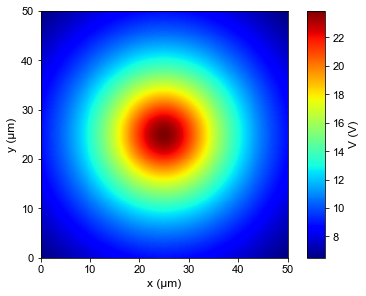

In [2]:
potential = lambda I, rho, r: rho * I / (4 * np.pi * r)
r = lambda x, y, dist, offset: np.sqrt(dist**2 + (x-offset)**2 + (y-offset)**2) 

# parameters
rho = 300e-2
I = 1e-3
start = 0
end = 50e-6
step = 0.1e-6
dist = 10e-6

# prepare plot
y, x = np.mgrid[slice(start, end, step), slice(start, end, step)]
values = potential(I, rho, r(x, y, dist, end/2))
cmap = plt.get_cmap('jet')

# plot results
fig = plt.figure(constrained_layout=True)
plot = plt.pcolormesh(x*1e6, y*1e6, values, cmap=cmap)
plt.xlabel("x (\u00B5m)")
plt.ylabel("y (\u00B5m)")
plt.axis('scaled')
cbar = fig.colorbar(plot)
cbar.set_label("V (V)")
plt.show()
fig.savefig(f"../figures/potential.png", dpi=500)

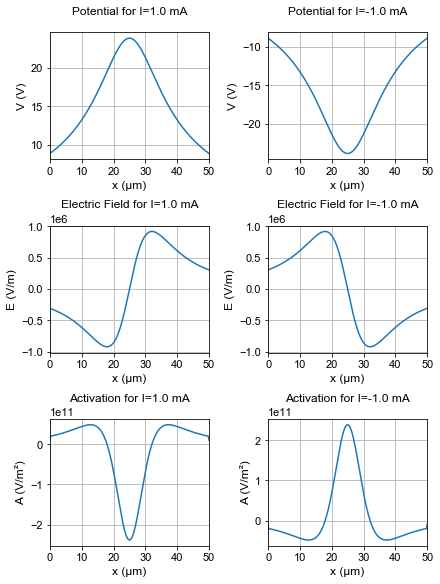

In [3]:
electric_field = lambda potential, dx: -np.gradient(potential, dx)*1e-2
activation = lambda electric_field, dx: -np.gradient(electric_field, dx)*1e-2
currents = [1e-3, -1e-3]

fig, axs = plt.subplots(3, 2, figsize=(6,8), constrained_layout=True)
i=0

for current in currents: 
    
    # plot potential
    x = np.arange(start, end, step)
    axon_potential = potential(current, rho, r(x, end/2, dist, end/2))
    axs[0,i].plot(x*1e6, axon_potential)
    axs[0,i].set_title(f"Potential for I={current*1e3} mA\n")
    axs[0,i].set_xlabel("x (\u00B5m)")
    axs[0,i].set_ylabel("V (V)")
    axs[0,i].set_xlim(start*1e6, end*1e6)
    axs[0,i].set_xticks(np.arange(start*1e6, end*1e6+1, 10))
    
    # plot electric field 
    dx = step/100
    axon_electric_field = electric_field(axon_potential, dx)
    axs[1,i].plot(x*1e6, axon_electric_field)
    axs[1,i].set_title(f"Electric Field for I={current*1e3} mA\n")
    axs[1,i].set_xlabel("x (\u00B5m)")
    axs[1,i].set_ylabel("E (V/m)")
    axs[1,i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1,i].set_xlim(start*1e6, end*1e6)
    axs[1,i].set_xticks(np.arange(start*1e6, end*1e6+1, 10))
    
    # plot activation function
    axon_activation = activation(axon_electric_field, dx)
    axs[2,i].plot(x*1e6, axon_activation)
    axs[2,i].set_title(f"Activation for I={current*1e3} mA\n")
    axs[2,i].set_xlabel("x (\u00B5m)")
    axs[2,i].set_ylabel("A (V/m\u00B2)")
    axs[2,i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[2,i].set_xlim(start*1e6, end*1e6)
    axs[2,i].set_xticks(np.arange(start*1e6, end*1e6+1, 10))
    
    i+=1
    
fig.savefig(f"../figures/potential_and_derivatives.pdf")

## Subtask 2 - Create a Neuron Model

In [4]:
# define rate equations
alpha_m = lambda V: (2.5 - 0.1*V) / (np.exp(2.5 - 0.1*V) - 1)
alpha_n = lambda V: (0.1 - 0.01*V) / (np.exp(1 - 0.1*V) - 1)
alpha_h = lambda V: 0.07 * np.exp(- V/20)
beta_m = lambda V: 4 * np.exp(- V/18)
beta_n = lambda V: 0.125 * np.exp(- V/80)
beta_h = lambda V: 1 / (np.exp(3 - 0.1*V) + 1)

# temperature correction
k = lambda T: 3 ** (0.1*(T-6.3))

# time constant
tau_x = lambda alpha, beta, k: 1 / ((alpha + beta) * k)

# steady state value
x_inf = lambda alpha, beta: alpha / (alpha + beta)

# ionic currents
i_na = lambda m, h, V: 120 * m**3 * h * (V - 115)
i_k = lambda n, V: 36 * n**4 * (V + 12)
i_l = lambda V: 0.3 * (V - 10.6)

# gating odes in A, B form for Exponential Euler
A_m = lambda V, T: - 1 / tau_x(alpha_m(V), beta_m(V), k(T))
A_n = lambda V, T: - 1 / tau_x(alpha_n(V), beta_n(V), k(T))
A_h = lambda V, T: - 1 / tau_x(alpha_h(V), beta_h(V), k(T))
B_m = lambda V, T: x_inf(alpha_m(V), beta_m(V)) / tau_x(alpha_m(V), beta_m(V), k(T))
B_n = lambda V, T: x_inf(alpha_n(V), beta_n(V)) / tau_x(alpha_n(V), beta_n(V), k(T))
B_h = lambda V, T: x_inf(alpha_h(V), beta_h(V)) / tau_x(alpha_h(V), beta_h(V), k(T))

def exponential_euler_step(A, B, prev_value, step_size):
    """One time step of Exponential Euler Method"""
    
    next_value = prev_value*np.exp(A*step_size) + B/A*(np.exp(A*step_size) - 1)
    
    return next_value

def explicit_euler_step(ode_rhs, prev_value, step_size):
    """One time step of Explicit Euler Method"""
    
    next_value = prev_value + ode_rhs * step_size
    
    return next_value

def connection_matrix(compartments): 
    C = np.eye(compartments)*-2
    C[0,0] = -1
    C[compartments-1, compartments-1] = -1
    for i in range (0, compartments):
        for j in range (0, compartments):
            if i == j + 1 or i == j - 1:
                C[i,j] = 1
    return C

def hh_current(V, T, prev_gating_vars, step_size):
    """Solves gating odes for one time step and returns ion currents and gating variables in next time step for all cells"""
    
    m = exponential_euler_step(A_m(V, T), B_m(V, T), prev_gating_vars[:,0].reshape(-1,1), step_size)
    n = exponential_euler_step(A_n(V, T), B_n(V, T), prev_gating_vars[:,1].reshape(-1,1), step_size)
    h = exponential_euler_step(A_h(V, T), B_h(V, T), prev_gating_vars[:,2].reshape(-1,1), step_size)
    
    i_ions = np.concatenate((i_na(m, h, V), i_k(n, V), i_l(V)), axis=1)
    gating_vars = np.concatenate((m, n, h), axis=1)
    
    return i_ions, gating_vars

def hh_model(T, 
             start_time, 
             end_time, 
             step_size, 
             compartments, 
             c_m, 
             r_a, 
             pulse_start_time, 
             pulse_duration, 
             phase, 
             current, 
             rho_medium, 
             l, 
             dist):
    """
    T:              temperature
    start_time:     starting time of simulation
    end_time:       ending time of simulation
    step_size:      step size
    compartments:   number of compartments
    get_i_stim:     function that returns stimulation current
    c_m:            membrane capacitance
    r_a:            axonal resistance
    """
    
    V_rest = 0
    V_membrane = np.full((1, compartments, 1), V_rest)
    times = np.arange(start_time, end_time, step_size)
    C = connection_matrix(compartments)
    
    # gating variables at resting potential for all cells
    m_inf = x_inf(alpha_m(V_membrane), beta_m(V_membrane))
    n_inf = x_inf(alpha_n(V_membrane), beta_n(V_membrane))
    h_inf = x_inf(alpha_h(V_membrane), beta_h(V_membrane))
    gating_vars = np.concatenate((m_inf, n_inf, h_inf), axis=2)
    
    # currents at resting potential for all cells
    i_ions = np.concatenate((i_na(m_inf, h_inf, V_membrane), i_k(n_inf, V_membrane), i_l(V_membrane)), axis=2)
    
    for time in times[1:]:
        
        # exponential euler step and append results
        next_i_ions, next_gating_vars = hh_current(V_membrane[-1], T, gating_vars[-1], step_size)
        i_ions = np.concatenate((i_ions, [next_i_ions]))
        gating_vars = np.concatenate((gating_vars, [next_gating_vars]))
        
        # get hodkin-huxley current and activation
        i_hh = np.sum(i_ions[-1], axis=1).reshape((-1,1))
        i_activation = get_i_activation(time, compartments, pulse_start_time, pulse_duration, phase, current, rho_medium, r_a, l, dist)
       
        # solve cable equation
        A = np.eye(compartments) - step_size*C/(c_m*r_a)
        b = V_membrane[-1] + (step_size/c_m)*(np.matmul(C, i_activation) - i_hh)
        next_V_membrane = np.linalg.solve(A, b)
        
        # account for instability of solution and append results
        next_V_membrane[0:3] = next_V_membrane[4]
        next_V_membrane[-3:] = next_V_membrane[-4]
        V_membrane = np.concatenate((V_membrane, [next_V_membrane]))
        
    return V_membrane, gating_vars, i_ions, times

In [5]:
class SimulationType(Enum):
    mono = "mono"
    bi = "bi"

def get_i_activation(time, compartments, start_time, duration, phase, current, rho_medium, r_a, l, dist):
    """Generates current pulses at the correct time intervals"""
    if phase == SimulationType.mono:
       
        if time >= start_time and time < start_time + duration:
            i_activation = generate_pulse(compartments, current, rho_medium, r_a, l, dist)
        else:
            i_activation = np.zeros((compartments, 1))
    
    elif phase == SimulationType.bi:
        
        if time >= start_time and time < start_time + duration:
            i_activation = generate_pulse(compartments, -current, rho_medium, r_a, l, dist)
        elif time >= start_time + duration and time < start_time + 2*duration:
            i_activation = generate_pulse(compartments, current, rho_medium, r_a, l, dist)
        else:
            i_activation = np.zeros((compartments, 1))

    return i_activation.reshape((-1,1))

def generate_pulse(compartments, current, rho_medium, r_a, l, dist):
    """Returns a vector for activation current at each node of Ranvier"""
    
    # construct vector of distances to current source
    x = np.arange(0, l*(compartments-0.1), l)
    offset = l*compartments/2
    distances = r(x, offset, dist, offset)
    
    # calculate external potential at each node and convert to mV
    ext_potential = potential(current, rho_medium, distances) * 1000
    
    i_activation = ext_potential / r_a
    
    return i_activation

Running simulation --mono-- with amplitude -0.00025


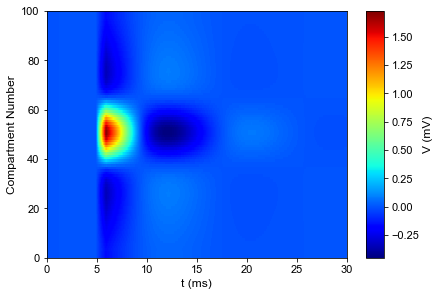

Running simulation --mono-- with amplitude -0.001


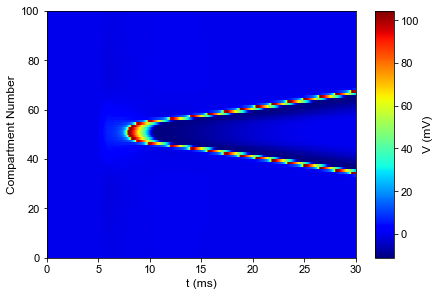

Running simulation --mono-- with amplitude 0.00025


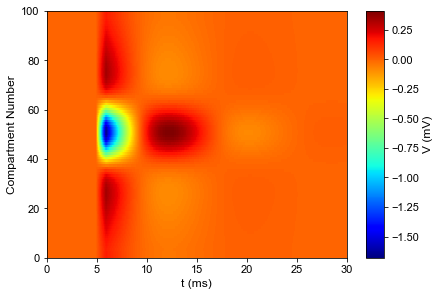

Running simulation --mono-- with amplitude 0.005


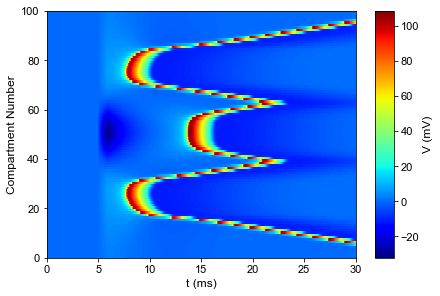

Running simulation --bi-- with amplitude 0.0005


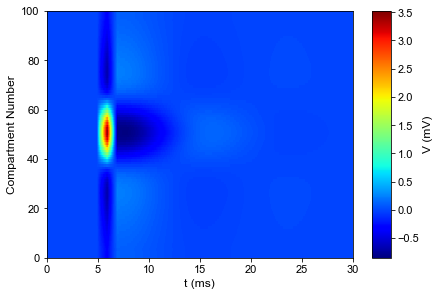

Running simulation --bi-- with amplitude 0.002


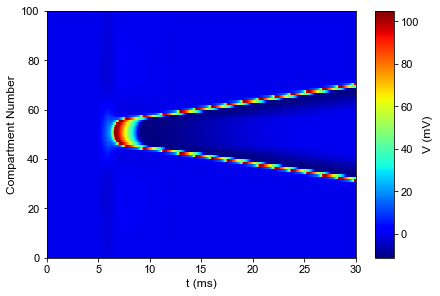

In [6]:
resistance = lambda rho, r, l: rho * l / (np.pi * r**2)

# neuron parameters
rho_axon = 10e-5
r_axon = 1.5e-6
l_comp = 0.5e-6

# HH model parameters 
r_a = resistance(rho_axon, r_axon, l_comp)
step_size = 0.025
start_time = 0
end_time = 30
temperature = 6.3
capacity = 1
no_compartments = 101

# stimulation parameters
pulse_start_time = 5
pulse_duration = 1
rho_medium = 300e-2
source_distance = 10e-6
simulations = [(SimulationType.mono, -0.25e-3), 
               (SimulationType.mono, -1e-3), 
               (SimulationType.mono, 0.25e-3), 
               (SimulationType.mono, 5e-3), 
               (SimulationType.bi, 0.5e-3),
               (SimulationType.bi, 2e-3)]

for simulation in simulations:
    
    print(f"Running simulation --{simulation[0].value}-- with amplitude {simulation[1]}")
    
    # run simulation 
    V_membrane, gating_vars, i_ions, times = hh_model(temperature, 
                                                      start_time, 
                                                      end_time, 
                                                      step_size, 
                                                      no_compartments, 
                                                      capacity, 
                                                      r_a, 
                                                      pulse_start_time, 
                                                      pulse_duration, 
                                                      simulation[0], 
                                                      simulation[1], 
                                                      rho_medium, 
                                                      l_comp, 
                                                      source_distance)
    
    # prepare plot 
    y, x = np.mgrid[slice(0, no_compartments, 1), slice(start_time, end_time, step_size)]
    cmap = plt.get_cmap('jet')
    
    # plot results
    fig = plt.figure(constrained_layout=True)
    V_membrane = np.swapaxes(V_membrane, 0, 2)
    plot = plt.pcolormesh(x, y, V_membrane[-1], cmap=cmap)
    plt.xlabel("t (ms)")
    plt.ylabel("Compartment Number")
    plt.xlim(start_time, end_time)
    plt.ylim(0, no_compartments-1)
    cbar = fig.colorbar(plot)
    cbar.set_label("V (mV)")
    plt.show()
    fig.savefig(f"../figures/potential_{simulation[0]}_amp{simulation[1]}.png", dpi=500)